In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('songsDataset.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


songsDataset.csv/songsDataset.csv


In [5]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import ClusteringEvaluator


In [6]:
sc = SparkContext('local')
spark = SparkSession(sc)


# To read the data, we first need to desin an scheme with appropriate data types, matching with CSV file inputs. Our dataset has three fields namely userID, songID, and rating.



In [7]:
input_schema = StructType([
    StructField('userID',IntegerType(), False),
    StructField('songID',IntegerType(), False),
])
data = spark.read.csv(
    'songsDataset.csv', header=True, schema=input_schema
).cache()


In [8]:
data.printSchema()


root
 |-- userID: integer (nullable = true)
 |-- songID: integer (nullable = true)



In [9]:
data.show(10)


+------+------+
|userID|songID|
+------+------+
|     0|  7171|
|     0|  8637|
|     0| 21966|
|     0| 35821|
|     0| 82446|
|     0| 90409|
|     0|107410|
|     0|131919|
|     0|132685|
|     0|136507|
+------+------+
only showing top 10 rows



In [10]:
#We transform our features and update our data.

vecAssembler = VectorAssembler(inputCols=['userID', 'songID'], outputCol="features")
data = vecAssembler.transform(data).select('features')
data.show()


+--------------+
|      features|
+--------------+
|  [0.0,7171.0]|
|  [0.0,8637.0]|
| [0.0,21966.0]|
| [0.0,35821.0]|
| [0.0,82446.0]|
| [0.0,90409.0]|
|[0.0,107410.0]|
|[0.0,131919.0]|
|[0.0,132685.0]|
|[0.0,136507.0]|
|  [1.0,3342.0]|
|  [1.0,7522.0]|
| [1.0,25363.0]|
| [1.0,38997.0]|
| [1.0,43685.0]|
| [1.0,45488.0]|
| [1.0,62770.0]|
|[1.0,109450.0]|
|[1.0,122506.0]|
|[1.0,130621.0]|
+--------------+
only showing top 20 rows



In [14]:
#Now, we have vectorised form of dataset. The first step of kmeans clustering is to exact the number of clusters. We need to know the value of k. For that, we, keep minimum number to 2 and check the cost incurred with various various of k. We check for range [2, 22]

cost = np.zeros(22)
for k in range(2,22):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(data.sample(False,0.1))
    cost[k] = model.computeCost(data)


Text(0, 0.5, 'cost')

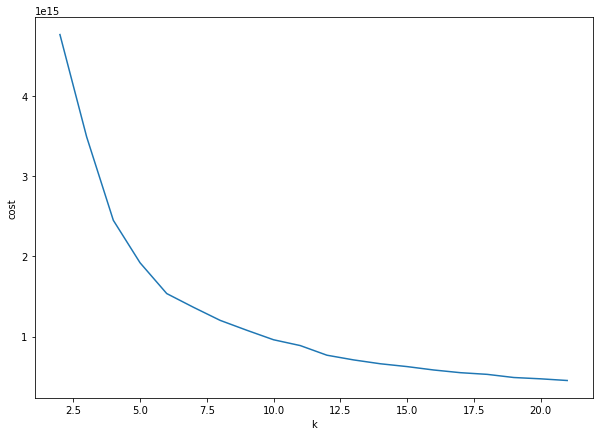

In [12]:
#Cost is initialized as an array with 22 values. Then, we fit and compute cost to build a list of costs with varying number of clusters.

fig, ax = plt.subplots(1,1, figsize =(10,7))
ax.plot(range(2,22),cost[2:22])
ax.set_xlabel('k')
ax.set_ylabel('cost')
